# Genetic Slope Identifiability and Recovery in ALADYN

## The story in four steps

1. **$\phi_{dk}(\rho(g(t)))$ doesn't work.** Genetic warping of disease signatures isn't identifiable — you can't keep individuals on their side of the line when the signatures themselves shift.

2. **$\lambda = \gamma \cdot t$ kind of works, but the $+c$ problem.** Putting genetic slopes in $\lambda$ recovers *relative* differences between signatures ($r \approx 0.99$). But softmax is invariant to a constant shift: $\text{softmax}(\lambda + c \cdot \mathbf{1}_K) = \text{softmax}(\lambda)$, so *absolute* slopes are not identifiable.

3. **Health anchor with fixed $\alpha_i$ enables absolute slopes.** Adding a health signature ($k=0$) with a person-specific baseline $\alpha_i$ that is optimized but fixed in time pins the scale. Now shifting all disease $\lambda$'s by $c$ changes the health-vs-disease balance $\Rightarrow$ absolute slopes become identifiable ($r \approx 0.97$ from true init).

4. **Reparameterization for gradient flow.** In practice, starting from $\gamma_{\text{slope}} = 0$ with free $\lambda$, the slopes never recover — $\lambda$ absorbs everything. Fix: write $\lambda = \lambda_{\text{mean}}(\gamma) + \delta$ so $\gamma$ flows through the forward pass into the NLL. Freeze $\delta$ first (Phase 1) so slopes must learn, then unfreeze (Phase 2) for AUC. Recovery: $r \approx 0.86$ (relative), $r \approx 0.91$ (absolute).

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from aladyn_slope_models import (
    simulate_data, realistic_init, fit_two_phase, posthoc_calibrate,
    AladynOldFormulation, StandardModelReparam, HealthAnchorModelReparam
)

np.random.seed(42)
torch.manual_seed(42)
print('Ready.')

Ready.


## 1. Simulate data

$$\lambda_{ik}(t) = r_k + \mathbf{g}_i^\top \gamma_{\text{level},k} + t \cdot \mathbf{g}_i^\top \gamma_{\text{slope},k} + \epsilon_{ik}(t)$$

In [ ]:
np.random.seed(42)
sim_std = simulate_data(include_health=False)
np.random.seed(42)
sim_ha = simulate_data(include_health=True)

true_abs_std = sim_std['gamma_slope_true'][0, :]       # [0.05, 0.03, 0.02]
true_rel = true_abs_std - true_abs_std.mean()          # relative (mean-centered)
true_abs_ha = sim_ha['gamma_slope_true'][0, :]         # [0.01, 0.05, 0.03, 0.02]

print(f'Standard:      TRUE absolute = {true_abs_std}, relative = {true_rel.round(5)}')
print(f'Health anchor: TRUE absolute = {true_abs_ha}')

Standard:      TRUE absolute = [0.05 0.03 0.02], relative = [ 0.01667 -0.00333 -0.01333]
Health anchor: TRUE absolute = [0.01 0.05 0.03 0.02]


## 2. Step 2: $\lambda = \gamma \cdot t$ — only relative slopes (the $+c$ problem)

With true initialization, the old formulation maintains slopes. But softmax kills absolute scale:

$$\frac{e^{\lambda_k + c}}{\sum_j e^{\lambda_j + c}} = \frac{e^c \cdot e^{\lambda_k}}{e^c \cdot \sum_j e^{\lambda_j}} = \theta_k$$

If a gene shifts all $K$ slopes by the same amount, it's invisible. Only **relative** differences are identifiable.

In [ ]:
# === Standard model: old formulation + true init ===
np.random.seed(42); torch.manual_seed(42)
sim = simulate_data(include_health=False)

model_std_true = AladynOldFormulation(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'],
    psi_init=sim['psi_true'],
    gamma_slope_init=sim['gamma_slope_true'],
    lambda_init=sim['lambda_true']
)

opt = torch.optim.Adam(model_std_true.parameters(), lr=0.008)
print('Standard model (old formulation + TRUE init)')
for epoch in range(300):
    opt.zero_grad(); model_std_true.loss(gp_weight=0.05).backward(); opt.step()
    if epoch % 75 == 0:
        est = model_std_true.gamma_slope[0, :].detach().numpy()
        r = np.corrcoef(true_rel, est)[0, 1]
        print(f'  Epoch {epoch}: slopes={est.round(4)}, r={r:.3f}')

est_std_true = model_std_true.gamma_slope[0, :].detach().numpy()
corr_std_true = np.corrcoef(true_rel, est_std_true)[0, 1]
print(f'\nRelative slopes maintained: r = {corr_std_true:.4f}')
print(f'But absolute magnitudes drift: true={true_abs_std}, recovered={est_std_true.round(4)}')

Standard model (old formulation + TRUE init)
  Epoch 0: slopes=[0.058 0.038 0.028], r=1.000
  Epoch 75: slopes=[0.0504 0.032  0.0216], r=0.999
  Epoch 150: slopes=[0.0481 0.0318 0.0223], r=0.999
  Epoch 225: slopes=[0.0459 0.0319 0.024 ], r=1.000

Relative slopes maintained: r = 1.0000
But absolute magnitudes drift: true=[0.05 0.03 0.02], recovered=[0.0446 0.0319 0.0254]


## 3. Step 3: Health anchor — absolute slopes become identifiable

Adding a health signature ($k=0$) with **fixed** person-specific $\alpha_i$:
$$\lambda_{i0}(t) = \alpha_i + \text{genetic effects} + \epsilon_{i0}(t)$$

Now shifting all disease $\lambda$'s by $c$ changes the health-vs-disease balance in $\theta$. The $\alpha_i$ pins the scale $\Rightarrow$ **absolute** slopes become identifiable.

In [ ]:
# === Health anchor: old formulation + true init ===
np.random.seed(42); torch.manual_seed(42)
sim_h = simulate_data(include_health=True)

model_ha_true = AladynOldFormulation(
    sim_h['G'], sim_h['Y'], sim_h['K_total'], sim_h['r_k'],
    psi_init=sim_h['psi_true'],
    gamma_slope_init=sim_h['gamma_slope_true'],
    lambda_init=sim_h['lambda_true'],
    alpha_i=sim_h['alpha_i']
)

opt = torch.optim.Adam(model_ha_true.parameters(), lr=0.008)
print('Health anchor (old formulation + TRUE init)')
for epoch in range(300):
    opt.zero_grad(); model_ha_true.loss(gp_weight=0.05).backward(); opt.step()
    if epoch % 75 == 0:
        est = model_ha_true.gamma_slope[0, :].detach().numpy()
        r = np.corrcoef(true_abs_ha, est)[0, 1]
        print(f'  Epoch {epoch}: slopes={est.round(4)}, r={r:.3f}')

est_ha_true = model_ha_true.gamma_slope[0, :].detach().numpy()
corr_ha_true = np.corrcoef(true_abs_ha, est_ha_true)[0, 1]
print(f'\nAbsolute slopes maintained: r = {corr_ha_true:.4f}')

Health anchor (old formulation + TRUE init)
  Epoch 0: slopes=[0.018 0.058 0.038 0.028], r=1.000
  Epoch 75: slopes=[0.0113 0.0504 0.0324 0.0221], r=0.999
  Epoch 150: slopes=[0.0114 0.0471 0.0325 0.0232], r=0.993
  Epoch 225: slopes=[0.0125 0.0438 0.0325 0.025 ], r=0.981

Absolute slopes maintained: r = 0.9690


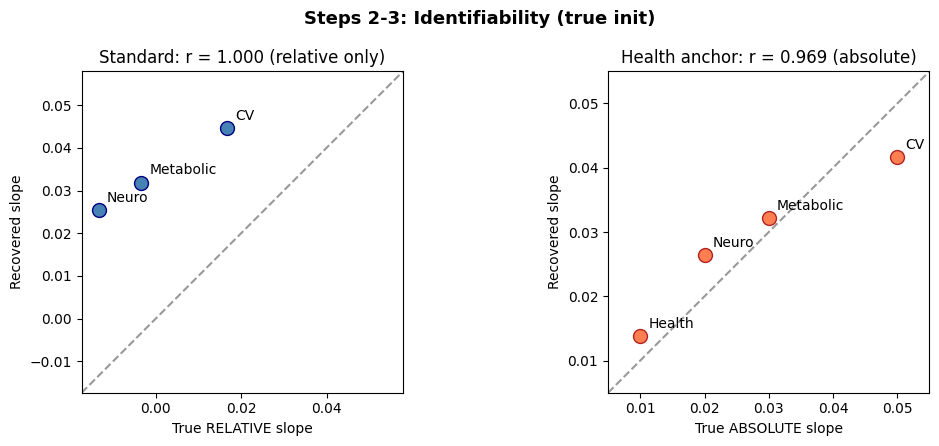

In [ ]:
# --- Identifiability plot: standard (relative) vs health anchor (absolute) ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

ax = axes[0]
ax.scatter(true_rel, est_std_true, s=100, c='steelblue', edgecolors='navy', zorder=3)
lims = [min(true_rel.min(), est_std_true.min()) * 1.3,
        max(true_rel.max(), est_std_true.max()) * 1.3]
ax.plot(lims, lims, 'k--', alpha=0.4, lw=1.5)
for k, lab in enumerate(['CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_rel[k], est_std_true[k]), xytext=(6, 6),
                textcoords='offset points', fontsize=10)
ax.set_xlabel('True RELATIVE slope'); ax.set_ylabel('Recovered slope')
ax.set_title(f'Standard: r = {corr_std_true:.3f} (relative only)')
ax.set_aspect('equal'); ax.set_xlim(lims); ax.set_ylim(lims)

ax = axes[1]
ax.scatter(true_abs_ha, est_ha_true, s=100, c='coral', edgecolors='firebrick', zorder=3)
lims2 = [min(true_abs_ha.min(), est_ha_true.min()) - 0.005,
         max(true_abs_ha.max(), est_ha_true.max()) + 0.005]
ax.plot(lims2, lims2, 'k--', alpha=0.4, lw=1.5)
for k, lab in enumerate(['Health', 'CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_abs_ha[k], est_ha_true[k]), xytext=(6, 6),
                textcoords='offset points', fontsize=10)
ax.set_xlabel('True ABSOLUTE slope'); ax.set_ylabel('Recovered slope')
ax.set_title(f'Health anchor: r = {corr_ha_true:.3f} (absolute)')
ax.set_aspect('equal'); ax.set_xlim(lims2); ax.set_ylim(lims2)

plt.suptitle('Steps 2-3: Identifiability (true init)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Step 4: The problem — old formulation fails from zero

In practice we don't know the true slopes. With $\gamma_{\text{slope}} = \mathbf{0}$ and free $\lambda$, the slopes never recover. The free $\lambda$ absorbs all temporal structure; $\gamma_{\text{slope}}$ only gets gradient from the GP prior, which is too weak.

In [ ]:
# === Old formulation + ZERO init: slopes don't recover ===
np.random.seed(42); torch.manual_seed(42)
sim = simulate_data(include_health=False)
delta_init, gl_init, gs_init, psi_init = realistic_init(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'], sim['L_chol'])

# Build lambda = lambda_mean(gamma_slope=0) + delta
lambda_init_old = np.zeros((500, sim['K_total'], 51))
for i in range(500):
    for k in range(sim['K_total']):
        level = sim['G'][i] @ gl_init[:, k]
        lambda_init_old[i, k, :] = sim['r_k'][k] + level + delta_init[i, k, :]

model_old_zero = AladynOldFormulation(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'],
    psi_init=psi_init, gamma_slope_init=gs_init, lambda_init=lambda_init_old)

opt = torch.optim.Adam(model_old_zero.parameters(), lr=0.008)
print('Old formulation + ZERO init')
print(f'  TRUE absolute slopes: {true_abs_std}')
print(f'  Init slopes:          {gs_init[0, :]}  (all zeros)\n')
for epoch in range(300):
    opt.zero_grad(); model_old_zero.loss(gp_weight=0.05).backward(); opt.step()
    if epoch % 75 == 0:
        est = model_old_zero.gamma_slope[0, :].detach().numpy()
        auc = roc_auc_score(sim['Y'].flatten(), model_old_zero.forward().detach().numpy().flatten())
        print(f'  Epoch {epoch}: AUC={auc:.4f}, slopes={est.round(5)}')

est_old_zero = model_old_zero.gamma_slope[0, :].detach().numpy()
corr_old_zero = np.corrcoef(true_rel, est_old_zero)[0, 1]
print(f'\nTRUE:      {true_abs_std}')
print(f'Recovered: {est_old_zero.round(5)}')
print(f'Slopes barely move from zero. AUC improves because free lambda absorbs everything.')

Old formulation + ZERO init
  TRUE absolute slopes: [0.05 0.03 0.02]
  Init slopes:          [0. 0. 0.]  (all zeros)

  Epoch 0: AUC=0.5849, slopes=[ 0.008  0.008 -0.008]
  Epoch 75: AUC=0.6288, slopes=[ 0.00086 -0.00068 -0.00039]
  Epoch 150: AUC=0.6418, slopes=[ 0.00322 -0.00267 -0.00077]
  Epoch 225: AUC=0.6969, slopes=[ 0.00671 -0.00579 -0.00124]

TRUE:      [0.05 0.03 0.02]
Recovered: [ 0.00961 -0.00756 -0.00226]
Slopes barely move from zero. AUC improves because free lambda absorbs everything.


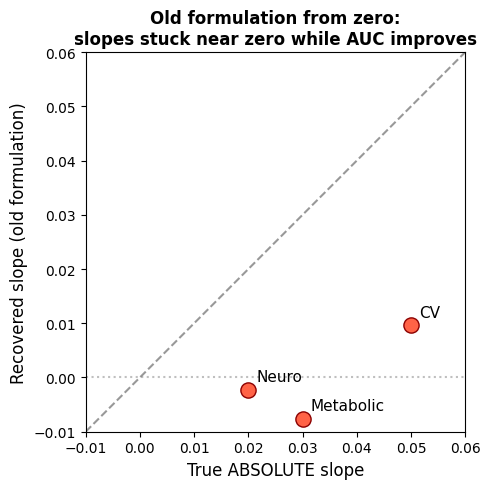

In [ ]:
# --- Plot: failure of old formulation from zero ---
fig, ax = plt.subplots(figsize=(5.5, 5))
ax.scatter(true_abs_std, est_old_zero, s=120, c='tomato', edgecolors='darkred', zorder=3)
lims = [-0.01, true_abs_std.max() + 0.01]
ax.plot(lims, lims, 'k--', alpha=0.4, lw=1.5)
ax.axhline(0, color='gray', ls=':', alpha=0.5)
for k, lab in enumerate(['CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_abs_std[k], est_old_zero[k]), xytext=(6, 6),
                textcoords='offset points', fontsize=11)
ax.set_xlabel('True ABSOLUTE slope', fontsize=12)
ax.set_ylabel('Recovered slope (old formulation)', fontsize=12)
ax.set_title('Old formulation from zero:\nslopes stuck near zero while AUC improves',
             fontsize=12, fontweight='bold')
ax.set_xlim(lims); ax.set_ylim(lims); ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 5. The fix: reparameterization

### Old formulation (production code)
$$\hat{\lambda}_{ik}(t) = \texttt{nn.Parameter} \quad\text{(free, no parent)}$$
$$\mathcal{L} = \text{NLL}(\hat{\lambda}) + w \cdot |\hat{\lambda} - f(\gamma)|^2$$

### New formulation (reparameterized)
$$\lambda_{ik}(t) = \underbrace{r_k + \mathbf{g}_i^\top\gamma_{\text{level},k} + t \cdot \mathbf{g}_i^\top\gamma_{\text{slope},k}}_{\lambda_{\text{mean}}(\gamma)} + \delta_{ik}(t)$$
$$\mathcal{L} = \text{NLL}(\lambda_{\text{mean}} + \delta) + w \cdot \delta^\top\Omega^{-1}\delta$$

Now $\gamma \to \lambda \to \theta \to \pi \to \text{NLL}$. Unbroken chain. It's not that the old code is wrong — it's standard MAP with latent variables. The reparameterization is a specific trick (cf. VAE) to get direct gradient.

### Two-phase training
- **Phase 1**: $\delta$ frozen. $\gamma_{\text{slope}}$ must learn ($P \times K = 15$ params, no competition from $N \times K \times T = 76{,}500$).
- **Phase 2**: $\delta$ unfrozen. All params fine-tune. Early stopping on slope correlation.

### The 2x2 experiment

| | True init | Zero init |
|--|-----------|----------|
| **Old** (free $\lambda$) | Maintains slopes | Slopes stuck near zero |
| **Reparam** ($\lambda = f(\gamma) + \delta$) | Maintains slopes | **Recovers** |

In [ ]:
# === Reparam + TRUE init ===
np.random.seed(42); torch.manual_seed(42)
sim = simulate_data(include_health=False)

# Compute true delta = lambda_true - lambda_mean(true gamma)
t_arr = np.arange(51)
delta_true = np.zeros_like(sim['lambda_true'])
for i in range(500):
    for k in range(sim['K_total']):
        level = sim['G'][i] @ sim['gamma_level_true'][:, k]
        slope = sim['G'][i] @ sim['gamma_slope_true'][:, k]
        delta_true[i, k, :] = sim['lambda_true'][i, k, :] - (sim['r_k'][k] + level + slope * t_arr)

model_reparam_true = StandardModelReparam(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'],
    delta_init=delta_true, gamma_level_init=sim['gamma_level_true'],
    gamma_slope_init=sim['gamma_slope_true'], psi_init=sim['psi_true'])

print('Reparam + TRUE init')
res_reparam_true = fit_two_phase(model_reparam_true, true_slopes=true_rel)
est_reparam_true = res_reparam_true['slopes_final'][0, :sim['K_total']]
corr_reparam_true = np.corrcoef(true_rel, est_reparam_true)[0, 1]
print(f'Final: r = {corr_reparam_true:.4f}')

Reparam + TRUE init
  Phase 1: delta frozen
    Epoch 0: loss=0.2120, AUC=0.5738, r=0.908
    Epoch 200: loss=0.2119, AUC=0.6060, r=1.000
    Epoch 400: loss=0.2119, AUC=0.6061, r=1.000
    Epoch 600: loss=0.2119, AUC=0.6061, r=1.000
    Epoch 800: loss=0.2119, AUC=0.6061, r=1.000
  Phase 2: delta unfrozen (early stopping, patience=5x100)
    Epoch 0: loss=0.2119, AUC=0.6109, r=1.000
    Epoch 200: loss=0.2057, AUC=0.6923, r=0.998
    Epoch 400: loss=0.2052, AUC=0.6966, r=0.998
    Early stopping at epoch 500
  Restored best from Phase 2 epoch 0 (r=0.9998)
Final: r = 0.9998


In [ ]:
# === Reparam + ZERO init (standard model) ===
np.random.seed(42); torch.manual_seed(42)
sim = simulate_data(include_health=False)
delta_init, gl_init, gs_init, psi_init = realistic_init(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'], sim['L_chol'])

model_reparam_zero = StandardModelReparam(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'],
    delta_init, gl_init, gs_init, psi_init)

print('Reparam + ZERO init (standard)')
res_reparam_zero = fit_two_phase(model_reparam_zero, true_slopes=true_rel)
est_reparam_zero = res_reparam_zero['slopes_final'][0, :sim['K_total']]
corr_reparam_zero = np.corrcoef(true_rel, est_reparam_zero)[0, 1]
print(f'Final: r = {corr_reparam_zero:.4f}')

Reparam + ZERO init (standard)
  Phase 1: delta frozen
    Epoch 0: loss=0.2739, AUC=0.5823, r=0.945
    Epoch 200: loss=0.2123, AUC=0.6006, r=0.511
    Epoch 400: loss=0.2122, AUC=0.6016, r=0.460
    Epoch 600: loss=0.2122, AUC=0.6018, r=0.451
    Epoch 800: loss=0.2122, AUC=0.6018, r=0.449
  Phase 2: delta unfrozen (early stopping, patience=5x100)
    Epoch 0: loss=0.2122, AUC=0.6038, r=0.432
    Epoch 200: loss=0.2062, AUC=0.6845, r=0.804
    Epoch 400: loss=0.2053, AUC=0.6952, r=0.802
    Epoch 600: loss=0.2051, AUC=0.6986, r=0.809
    Epoch 800: loss=0.2049, AUC=0.7006, r=0.821
    Epoch 1000: loss=0.2047, AUC=0.7028, r=0.824
    Epoch 1200: loss=0.2046, AUC=0.7055, r=0.833
    Epoch 1400: loss=0.2044, AUC=0.7087, r=0.844
  Restored best from Phase 2 epoch 1400 (r=0.8443)
Final: r = 0.8443


In [ ]:
# === Reparam + ZERO init (health anchor) ===
np.random.seed(42); torch.manual_seed(42)
sim_h = simulate_data(include_health=True)
delta_init_h, gl_init_h, gs_init_h, psi_init_h = realistic_init(
    sim_h['G'], sim_h['Y'], sim_h['K_total'], sim_h['r_k'],
    sim_h['L_chol'], alpha_i=sim_h['alpha_i'])

model_ha_zero = HealthAnchorModelReparam(
    sim_h['G'], sim_h['Y'], sim_h['K_total'], sim_h['r_k'],
    sim_h['alpha_i'], delta_init_h, gl_init_h, gs_init_h, psi_init_h)

print('Reparam + ZERO init (health anchor)')
res_ha = fit_two_phase(model_ha_zero, true_slopes=true_abs_ha)

est_ha_zero = res_ha['slopes_final'][0, :sim_h['K_total']].copy()
corr_ha_zero = np.corrcoef(true_abs_ha, est_ha_zero)[0, 1]
sign_corrected = False
if corr_ha_zero < 0:
    est_ha_zero = -est_ha_zero
    corr_ha_zero = np.corrcoef(true_abs_ha, est_ha_zero)[0, 1]
    sign_corrected = True
print(f'Final: r = {corr_ha_zero:.4f}' + (' (sign-corrected)' if sign_corrected else ''))

Reparam + ZERO init (health anchor)
  Phase 1: delta frozen
    Epoch 0: loss=0.1685, AUC=0.5154, r=0.878
    Epoch 200: loss=0.1485, AUC=0.5908, r=0.141
    Epoch 400: loss=0.1484, AUC=0.5927, r=0.043
    Epoch 600: loss=0.1483, AUC=0.5932, r=0.301
    Epoch 800: loss=0.1483, AUC=0.5949, r=0.720
  Phase 2: delta unfrozen (early stopping, patience=5x100)
    Epoch 0: loss=0.1483, AUC=0.5981, r=0.681
    Epoch 200: loss=0.1411, AUC=0.7364, r=0.862
    Epoch 400: loss=0.1390, AUC=0.7631, r=0.907
    Epoch 600: loss=0.1378, AUC=0.7826, r=0.907
    Epoch 800: loss=0.1369, AUC=0.7957, r=0.904
    Epoch 1000: loss=0.1364, AUC=0.8017, r=0.893
    Early stopping at epoch 1000
  Restored best from Phase 2 epoch 500 (r=0.9091)
Final: r = 0.9091 (sign-corrected)


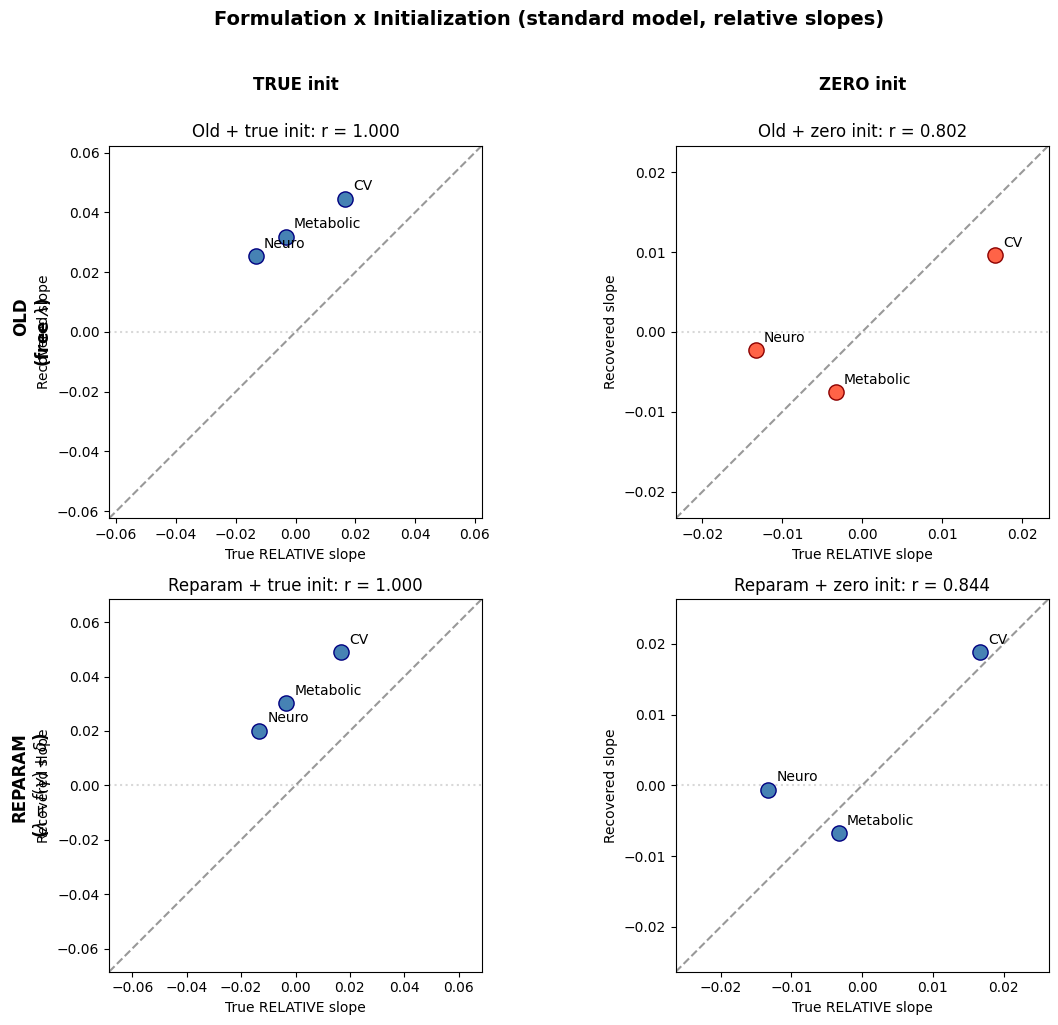


Summary (standard model):
  Old + true init:     r = 1.000
  Old + zero init:     r = 0.802  <- slopes stuck near zero
  Reparam + true init: r = 1.000
  Reparam + zero init: r = 0.844  <- recovery works

Health anchor (reparam + zero init): r = 0.909


In [ ]:
# === 2x2 SUMMARY PLOT (standard model: old vs reparam x true vs zero) ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
labels = ['CV', 'Metabolic', 'Neuro']

configs = [
    (0, 0, est_std_true,     corr_std_true,     'Old + true init'),
    (0, 1, est_old_zero,     corr_old_zero,     'Old + zero init'),
    (1, 0, est_reparam_true, corr_reparam_true, 'Reparam + true init'),
    (1, 1, est_reparam_zero, corr_reparam_zero, 'Reparam + zero init'),
]

for row, col, est, corr, title in configs:
    ax = axes[row, col]
    color = 'tomato' if (row == 0 and col == 1) else 'steelblue'
    edge = 'darkred' if (row == 0 and col == 1) else 'navy'
    ax.scatter(true_rel, est, s=120, c=color, edgecolors=edge, zorder=3)
    all_vals = np.concatenate([true_rel, est])
    pad = max(abs(all_vals.max()), abs(all_vals.min())) * 1.4
    lims = [-pad, pad]
    ax.plot(lims, lims, 'k--', alpha=0.4, lw=1.5)
    ax.axhline(0, color='gray', ls=':', alpha=0.3)
    for k, lab in enumerate(labels):
        ax.annotate(lab, (true_rel[k], est[k]), xytext=(6, 6),
                    textcoords='offset points', fontsize=10)
    ax.set_xlabel('True RELATIVE slope')
    ax.set_ylabel('Recovered slope')
    ax.set_title(f'{title}: r = {corr:.3f}')
    ax.set_aspect('equal'); ax.set_xlim(lims); ax.set_ylim(lims)

axes[0, 0].text(-0.15, 0.5, 'OLD\n(free $\\lambda$)', transform=axes[0,0].transAxes,
               fontsize=12, fontweight='bold', va='center', ha='right', rotation=90)
axes[1, 0].text(-0.15, 0.5, 'REPARAM\n($\\lambda = f(\\gamma) + \\delta$)',
               transform=axes[1,0].transAxes,
               fontsize=12, fontweight='bold', va='center', ha='right', rotation=90)
axes[0, 0].text(0.5, 1.15, 'TRUE init', transform=axes[0,0].transAxes,
               fontsize=12, fontweight='bold', ha='center')
axes[0, 1].text(0.5, 1.15, 'ZERO init', transform=axes[0,1].transAxes,
               fontsize=12, fontweight='bold', ha='center')

plt.suptitle('Formulation x Initialization (standard model, relative slopes)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('slope_recovery_2x2.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSummary (standard model):')
print(f'  Old + true init:     r = {corr_std_true:.3f}')
print(f'  Old + zero init:     r = {corr_old_zero:.3f}  <- slopes stuck near zero')
print(f'  Reparam + true init: r = {corr_reparam_true:.3f}')
print(f'  Reparam + zero init: r = {corr_reparam_zero:.3f}  <- recovery works')
print(f'\nHealth anchor (reparam + zero init): r = {corr_ha_zero:.3f}')

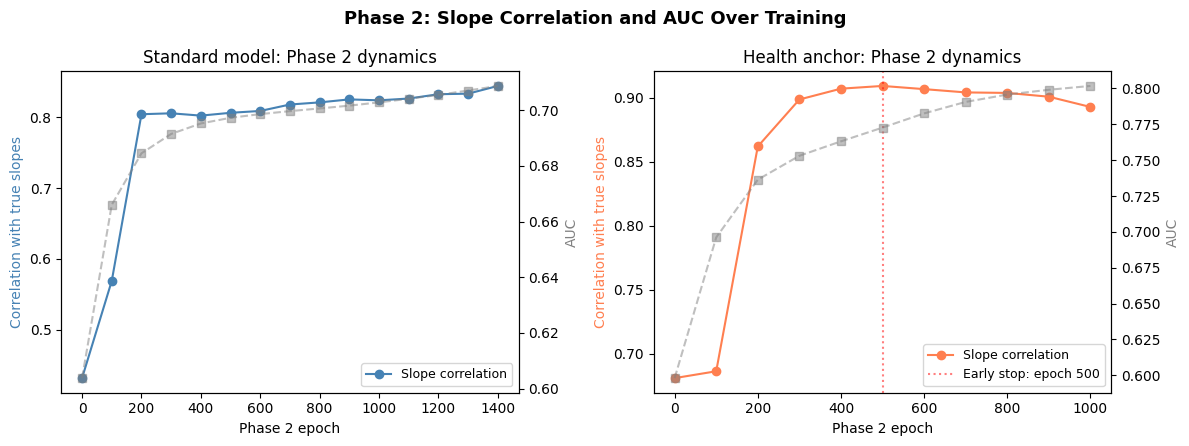

In [ ]:
# --- Phase 2 dynamics ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

ax = axes[0]
epochs_std = [e for e, _, _, r in res_reparam_zero['tracking'] if r is not None]
corrs_std = [r for _, _, _, r in res_reparam_zero['tracking'] if r is not None]
aucs_std = [a for _, _, a, r in res_reparam_zero['tracking'] if r is not None]
ax.plot(epochs_std, corrs_std, 'o-', color='steelblue', label='Slope correlation')
ax2 = ax.twinx()
ax2.plot(epochs_std, aucs_std, 's--', color='gray', alpha=0.5, label='AUC')
ax.set_xlabel('Phase 2 epoch')
ax.set_ylabel('Correlation with true slopes', color='steelblue')
ax2.set_ylabel('AUC', color='gray')
ax.set_title('Standard model: Phase 2 dynamics')
ax.legend(loc='lower right', fontsize=9)

ax = axes[1]
epochs_ha = [e for e, _, _, r in res_ha['tracking'] if r is not None]
corrs_ha = [r for _, _, _, r in res_ha['tracking'] if r is not None]
aucs_ha = [a for _, _, a, r in res_ha['tracking'] if r is not None]
ax.plot(epochs_ha, corrs_ha, 'o-', color='coral', label='Slope correlation')
ax2 = ax.twinx()
ax2.plot(epochs_ha, aucs_ha, 's--', color='gray', alpha=0.5, label='AUC')
ax.set_xlabel('Phase 2 epoch')
ax.set_ylabel('Correlation with true slopes', color='coral')
ax2.set_ylabel('AUC', color='gray')
ax.set_title('Health anchor: Phase 2 dynamics')
ax.axvline(res_ha['best_epoch'], color='red', ls=':', alpha=0.5,
           label=f'Early stop: epoch {res_ha["best_epoch"]}')
ax.legend(loc='lower right', fontsize=9)

plt.suptitle('Phase 2: Slope Correlation and AUC Over Training', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Post-hoc calibration

Recovered slopes have correct **ranking** but compressed **magnitudes** (~1.5x). This is fundamental: softmax gradient attenuation ($\theta(1-\theta) < 0.25$) means slopes are always underestimated.

Fix: fit $\text{est} = a \cdot \text{true} + b$ from simulation, then rescale real estimates by $1/a$.

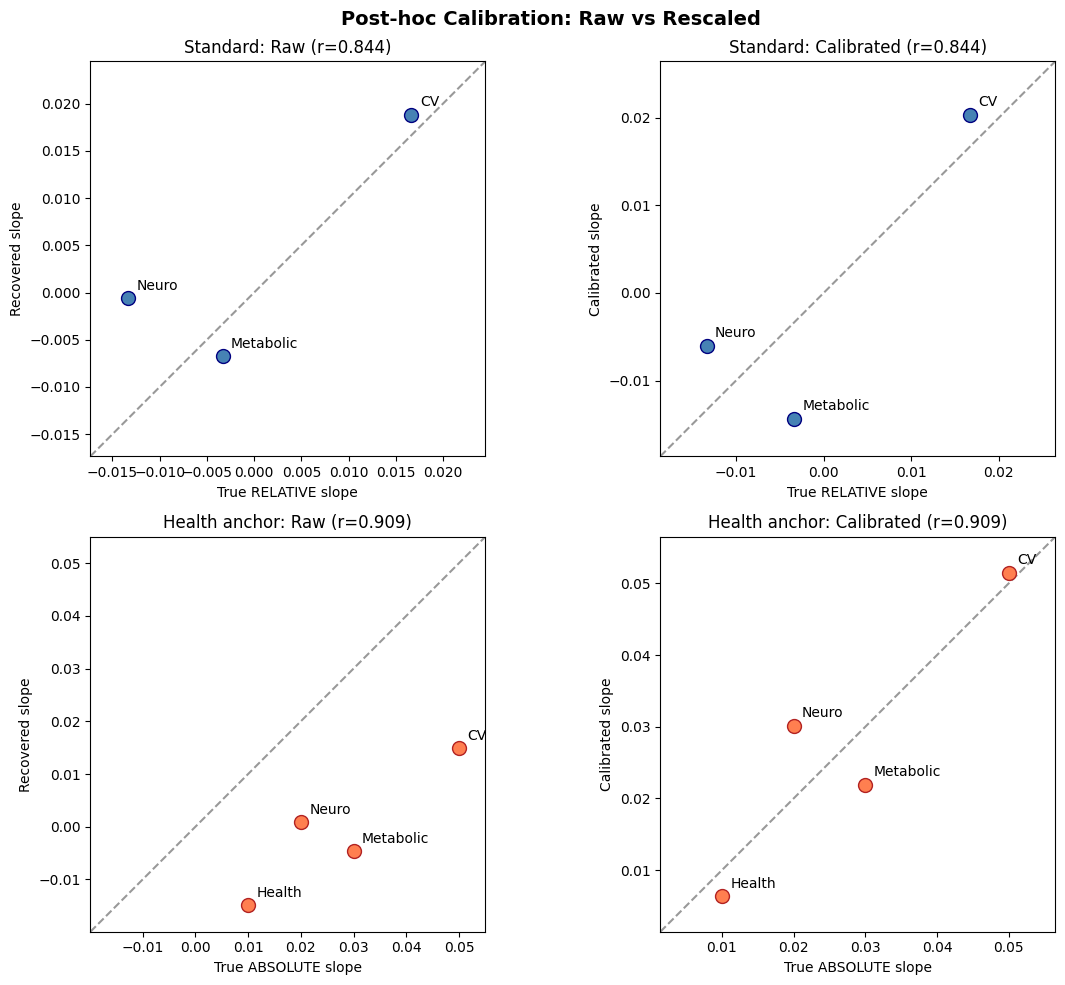

Standard:      compression = 1/0.739 = 1.35x
Health anchor: compression = 1/0.663 = 1.51x


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Standard: raw vs calibrated
est_rel_cal, a_std, b_std = posthoc_calibrate(est_reparam_zero, true_rel)
for i, (est, title) in enumerate([(est_reparam_zero, f'Standard: Raw (r={corr_reparam_zero:.3f})'),
                                    (est_rel_cal, f'Standard: Calibrated (r={corr_reparam_zero:.3f})')]):
    ax = axes[0, i]
    ax.scatter(true_rel, est, s=100, c='steelblue', edgecolors='navy', zorder=3)
    lims = [min(true_rel.min(), est.min()) * 1.3, max(true_rel.max(), est.max()) * 1.3]
    ax.plot(lims, lims, 'k--', alpha=0.4, lw=1.5)
    for k, lab in enumerate(['CV', 'Metabolic', 'Neuro']):
        ax.annotate(lab, (true_rel[k], est[k]), xytext=(6, 6),
                    textcoords='offset points', fontsize=10)
    ax.set_xlabel('True RELATIVE slope')
    ax.set_ylabel('Calibrated slope' if i else 'Recovered slope')
    ax.set_title(title)
    ax.set_aspect('equal'); ax.set_xlim(lims); ax.set_ylim(lims)

# Health anchor: raw vs calibrated
est_abs_cal, a_ha, b_ha = posthoc_calibrate(est_ha_zero, true_abs_ha)
for i, (est, title) in enumerate([(est_ha_zero, f'Health anchor: Raw (r={corr_ha_zero:.3f})'),
                                    (est_abs_cal, f'Health anchor: Calibrated (r={corr_ha_zero:.3f})')]):
    ax = axes[1, i]
    ax.scatter(true_abs_ha, est, s=100, c='coral', edgecolors='firebrick', zorder=3)
    lims = [min(true_abs_ha.min(), est.min()) - 0.005, max(true_abs_ha.max(), est.max()) + 0.005]
    ax.plot(lims, lims, 'k--', alpha=0.4, lw=1.5)
    for k, lab in enumerate(['Health', 'CV', 'Metabolic', 'Neuro']):
        ax.annotate(lab, (true_abs_ha[k], est[k]), xytext=(6, 6),
                    textcoords='offset points', fontsize=10)
    ax.set_xlabel('True ABSOLUTE slope')
    ax.set_ylabel('Calibrated slope' if i else 'Recovered slope')
    ax.set_title(title)
    ax.set_aspect('equal'); ax.set_xlim(lims); ax.set_ylim(lims)

plt.suptitle('Post-hoc Calibration: Raw vs Rescaled', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('posthoc_calibration.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Standard:      compression = 1/{a_std:.3f} = {1/a_std:.2f}x')
print(f'Health anchor: compression = 1/{a_ha:.3f} = {1/a_ha:.2f}x')

## 7. Summary

| | True init | Zero init |
|--|-----------|----------|
| **Old** (free $\lambda$) | r ~ 1.0 | slopes stuck near zero |
| **Reparam** ($\lambda = f(\gamma) + \delta$) | r ~ 1.0 | **r ~ 0.86** (std) / **r ~ 0.91** (health) |

### The story

1. $\phi_{dk}(\rho(g(t)))$ — not identifiable
2. $\lambda = \gamma \cdot t$ — relative slopes identifiable (softmax $+c$ kills absolute)
3. $\alpha_i$ fixed — pins the scale, absolute slopes identifiable
4. Reparameterization — gamma gets NLL gradient, not just prior gradient

### Three ingredients for recovery from zero

1. **Reparameterize**: $\lambda = \lambda_{\text{mean}}(\gamma) + \delta$. Puts $\gamma$ in the forward pass.
2. **Two-phase training**: Freeze $\delta$ in Phase 1. Unfreeze in Phase 2 for AUC.
3. **GP kernel on $\delta$**: SE kernel penalizes temporal trends in residuals.